In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import PyPDF2
import numpy
import fitz
import re
import os


Extracción del proyecto NHANES 

In [24]:
# Rutas a los archivos NHANES (cambiá si están en otra carpeta)
ruta_medidas = r"C:\Users\Carla\Curso_reskilling_Data\Sprint-10\BMX_L.XPT"
ruta_demo = r"C:\Users\Carla\Curso_reskilling_Data\Sprint-10\DEMO_L.XPT"

# Cargar medidas físicas (cintura, cadera, altura, peso...)
df_medidas = pd.read_sas(ruta_medidas, format='xport')

# Cargar datos demográficos (edad y sexo)
df_demo = pd.read_sas(ruta_demo, format='xport')

# Unir ambos datasets por ID (SEQN)
df_merged = pd.merge(
    df_medidas,
    df_demo[['SEQN', 'RIAGENDR', 'RIDAGEYR']],
    on='SEQN',
    how='inner'
)

# Renombrar columnas para legibilidad
df_merged = df_merged.rename(columns={
    'RIAGENDR': 'Sexo',
    'RIDAGEYR': 'Edad',
    'BMXWAIST': 'Cintura',
    'BMXHIP': 'Cadera'
})

# Mapear sexo a texto
df_merged['Sexo'] = df_merged['Sexo'].map({1: 'Hombre', 2: 'Mujer'})

# Filtrar solo mujeres adultas (edad 18–64)
df_mujeres_adultas = df_merged[
    (df_merged['Sexo'] == 'Mujer') &
    (df_merged['Edad'] >= 18) &
    (df_merged['Edad'] <= 64)
]

df_mujeres_adultas = df_mujeres_adultas[['Edad', 'Sexo', 'Cintura', 'Cadera']]



In [25]:
df_mujeres_adultas
# devuelve 2394 filas
df_mujeres_adultas = df_mujeres_adultas.dropna() #algunos datos tenian NaN y no nos va a servir con seaborn 

df_mujeres_adultas 
# devuelve 2251 filas 

,Edad,Sexo,Cintura,Cadera
2,44.0,Mujer,93.5,98.0
7,27.0,Mujer,118.5,134.0
9,31.0,Mujer,131.0,138.5
10,33.0,Mujer,123.8,138.9
14,33.0,Mujer,142.5,146.1
...,...,...,...,...
8833,51.0,Mujer,111.0,106.4
8835,23.0,Mujer,124.1,130.0
8837,29.0,Mujer,137.2,145.7
8841,54.0,Mujer,84.6,98.0


# Extraccion de tallas europeas

### Mango

In [3]:
# Leer el archivo PDF
ruta_pdf = r'C:\Users\Carla\Curso_reskilling_Data\Sprint-10\Jeans rectos tiro alto - Mujer _ MANGO España (Península y Baleares).pdf'
with open(ruta_pdf, 'rb') as archivo:
    lector = PyPDF2.PdfReader(archivo)
    texto = ''
    for pagina in lector.pages:
        texto += pagina.extract_text()

# Usar regex para encontrar líneas con patrón: número, número, número si no le doy direcciones a la lectura del PDF lee cosas arbitrarias
patron = r'(\d{2})\s+(\d{2,3})\s+(\d{2,3})'
coincidencias = re.findall(patron, texto)

# Crear un DataFrame si se encuentran coincidencias
if coincidencias:
    df_mango = pd.DataFrame(coincidencias, columns=["Talla_EU", "Cintura", "Cadera"])
    df_mango[["Talla_EU", "Cintura", "Cadera"]] = df_mango[["Talla_EU", "Cintura", "Cadera"]].astype(int)

    # Añadir columna ID
    df_mango["ID"] = ["Mango_" + str(t) for t in df_mango["Talla_EU"]]

    df_mango["Marca"] = "Mango"
    df_mango["Producto"] = "Jeans rectos tiro alto"



else:
    print(" No se encontraron tallas con el patrón esperado.")

columnas = ["ID"] + [col for col in df_mango.columns if col != "ID"]
df_mango = df_mango[columnas]

columnas = ["ID", "Talla_EU", "Cintura", "Cadera", "Marca", "Producto"]

df_mango

,ID,Talla_EU,Cintura,Cadera,Marca,Producto
0,Mango_32,32,59,86,Mango,Jeans rectos tiro alto
1,Mango_34,34,62,90,Mango,Jeans rectos tiro alto
2,Mango_36,36,66,94,Mango,Jeans rectos tiro alto
3,Mango_38,38,70,98,Mango,Jeans rectos tiro alto
4,Mango_40,40,74,102,Mango,Jeans rectos tiro alto
5,Mango_42,42,78,106,Mango,Jeans rectos tiro alto
6,Mango_44,44,85,112,Mango,Jeans rectos tiro alto
7,Mango_46,46,92,118,Mango,Jeans rectos tiro alto
8,Mango_48,48,97,122,Mango,Jeans rectos tiro alto
9,Mango_50,50,102,126,Mango,Jeans rectos tiro alto


### Zara

Para leer el Pdf de Zara y que sea equivalente con el de Mango hay que multiplicar por 2 las tallas de cintura y cadera 

porque Zara tiene las medidas en formato plano (te muestran la mitad de la medida)

In [4]:
# Ruta al nuevo PDF de Zara
ruta_pdf = r'C:\Users\Carla\Curso_reskilling_Data\Sprint-10\JEANS Z1975 STRAIGHT TIRO ALTO LONG LENGTH - Azul claro _ ZARA_02 España.pdf'

# Leer PDF
with open(ruta_pdf, 'rb') as archivo:
    lector = PyPDF2.PdfReader(archivo)
    texto = ''
    for pagina in lector.pages:
        texto += pagina.extract_text()

# Separar en líneas
lineas = texto.strip().split('\n')

# Extraer todas las líneas con 6 valores numéricos
bloque_medidas = []
for linea in lineas:
    numeros = linea.strip().split()
    if len(numeros) == 6 and all(n.replace('.', '', 1).isdigit() for n in numeros):
        bloque_medidas.append([float(n) for n in numeros])

# Verificar que hay al menos 4 filas (tallas + 3 medidas)
if len(bloque_medidas) >= 4:
    tallas = [int(n) for n in bloque_medidas[0]]
    cintura = [x * 2 for x in bloque_medidas[1]]
    cadera = [x * 2 for x in bloque_medidas[2]]


    df_zara = pd.DataFrame({
        "Talla_EU": tallas,
        "Cintura": cintura,
        "Cadera": cadera,
        "Marca": "Zara",
        "Producto": "Jeans Z1975 STRAIGHT TIRO ALTO LONG LENGTH"
    })

    df_zara["ID"] = df_zara["Marca"] + "_" + df_zara["Talla_EU"].astype(str)
    columnas_ordenadas = ["ID", "Talla_EU", "Cintura", "Cadera", "Marca", "Producto"]
    df_zara = df_zara[columnas_ordenadas]


else:
    print(" No se pudieron organizar los datos. Verifica el contenido.")


df_zara

,ID,Talla_EU,Cintura,Cadera,Marca,Producto
0,Zara_32,32,59.0,87.0,Zara,Jeans Z1975 STRAIGHT TIRO ALTO LONG LENGTH
1,Zara_34,34,63.0,91.0,Zara,Jeans Z1975 STRAIGHT TIRO ALTO LONG LENGTH
2,Zara_36,36,67.0,95.0,Zara,Jeans Z1975 STRAIGHT TIRO ALTO LONG LENGTH
3,Zara_38,38,71.0,99.0,Zara,Jeans Z1975 STRAIGHT TIRO ALTO LONG LENGTH
4,Zara_40,40,75.0,103.0,Zara,Jeans Z1975 STRAIGHT TIRO ALTO LONG LENGTH
5,Zara_42,42,79.0,107.0,Zara,Jeans Z1975 STRAIGHT TIRO ALTO LONG LENGTH


### H&M

H&M tiene cada talla en una pestaña, hay que hacer una lectura de varios archivos 

In [5]:
# Ruta a la carpeta donde están los archivos PDF de H&M
carpeta = r'C:\Users\Carla\Curso_reskilling_Data\Sprint-10'
archivos_hm = sorted([os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith(".pdf") and "H&M" in f])

# Lista para acumular DataFrames individuales
dfs = []

for archivo in archivos_hm:
    with open(archivo, 'rb') as f:
        lector = PyPDF2.PdfReader(f)
        texto = ''
        for pagina in lector.pages:
            texto += pagina.extract_text()

    lineas = texto.strip().split("\n")

    try:
        # Extraer tallas desde línea 6
        tallas = re.findall(r'\d+', lineas[6])
        tallas = [int(t) for t in tallas if 30 <= int(t) <= 70]
        n = len(tallas)

        # Extraer medidas
        cintura = re.findall(r'\d{2,3}', lineas[7])
        cadera = re.findall(r'\d{2,3}', lineas[8])
        entrepierna = re.findall(r'\d{2,3}(?:\.\d)?', lineas[14])

        if len(cintura) >= n and len(cadera) >= n and len(entrepierna) >= n:
            df = pd.DataFrame({
                "ID": [f"H&M_{t}" for t in tallas],
                "Talla_EU": tallas,
                "Cintura": [int(x) for x in cintura[:n]],
                "Cadera": [int(x) for x in cadera[:n]],
                "Marca": "H&M",
                "Producto": "Straight High Ankle Jeans"
            })
            dfs.append(df)
        else:
            print(f" Medidas incompletas en: {os.path.basename(archivo)}")

    except Exception as e:
        print(f" Error procesando {os.path.basename(archivo)}: {e}")

# Combinar todos los DataFrames en uno solo
df_hm_total = pd.concat(dfs, ignore_index=True)



df_hm_total

,ID,Talla_EU,Cintura,Cadera,Marca,Producto
0,H&M_30,30,59,78,H&M,Straight High Ankle Jeans
1,H&M_32,32,62,82,H&M,Straight High Ankle Jeans
2,H&M_34,34,62,82,H&M,Straight High Ankle Jeans
3,H&M_36,36,66,90,H&M,Straight High Ankle Jeans
4,H&M_38,38,70,94,H&M,Straight High Ankle Jeans
5,H&M_40,40,70,94,H&M,Straight High Ankle Jeans
6,H&M_42,42,78,100,H&M,Straight High Ankle Jeans
7,H&M_44,44,82,103,H&M,Straight High Ankle Jeans
8,H&M_46,46,82,103,H&M,Straight High Ankle Jeans
9,H&M_48,48,93,110,H&M,Straight High Ankle Jeans


# Extraccion de tallas estadounidenses

### American Eagle

In [6]:
# Ruta al PDF (ajustá según corresponda)
ruta_pdf = r'C:\Users\Carla\Curso_reskilling_Data\Sprint-10\AmericanEagle Super High-Waisted Wide-Leg Jean holgado stretch con drapeado de ensueño.pdf'

# Leer el texto del PDF
texto = ''
with open(ruta_pdf, 'rb') as archivo:
    lector = PyPDF2.PdfReader(archivo)
    for pagina in lector.pages:
        texto += pagina.extract_text()

# Expresión regular para capturar: talla (000, 00, 0, 2, ...), cintura, cadera
patron = r'\b(000|00|0|2|4|6|8|10|12|14|16|18|20)\b\s+(\d{2,3})\s+(\d{2,3})'
coincidencias = re.findall(patron, texto)

# Procesar si encuentra datos
if coincidencias:
    df_ae = pd.DataFrame(coincidencias, columns=["Talla_USA", "Cintura", "Cadera"])
    df_ae = df_ae.astype({"Talla_USA": str, "Cintura": int, "Cadera": int})

    #  Filtrar medidas realistas porque me daba duplicados que no tenian sentido 
    df_ae = df_ae[
        (df_ae["Cintura"] >= 50) & (df_ae["Cintura"] <= 100) &
        (df_ae["Cadera"] >= 70) & (df_ae["Cadera"] <= 130)
    ]

    # Eliminar duplicados (por errores de lectura repetida)
    df_ae = df_ae.drop_duplicates(subset="Talla_USA", keep="first")

    # Mapeo a talla europea
    mapa_us_eu = {
        "000": 28, "00": 30, "0": 32, "2": 34, "4": 36, "6": 38, "8": 40,
        "10": 42, "12": 44, "14": 46, "16": 48, "18": 50, "20": 52
    }
    df_ae["Talla_EU"] = df_ae["Talla_USA"].map(mapa_us_eu)

    # Agregar columnas fijas
    df_ae["Marca"] = "American Eagle"
    df_ae["Producto"] = "Super High-Waisted Wide-Leg Jean"
    df_ae["ID"] = df_ae["Marca"] + "_" + df_ae["Talla_USA"]

    # Reordenar columnas
    columnas = ["ID", "Talla_USA", "Talla_EU", "Cintura", "Cadera", "Marca", "Producto"]
    df_ae = df_ae[columnas]

else:
    print(" No se encontraron datos con el formato esperado.")

# Mostrar resultado
df_ae

,ID,Talla_USA,Talla_EU,Cintura,Cadera,Marca,Producto
0,American Eagle_000,000,28,57,81,American Eagle,Super High-Waisted Wide-Leg Jean
1,American Eagle_00,00,30,60,84,American Eagle,Super High-Waisted Wide-Leg Jean
3,American Eagle_0,0,32,62,86,American Eagle,Super High-Waisted Wide-Leg Jean
5,American Eagle_2,2,34,65,89,American Eagle,Super High-Waisted Wide-Leg Jean
7,American Eagle_4,4,36,67,91,American Eagle,Super High-Waisted Wide-Leg Jean
9,American Eagle_6,6,38,70,94,American Eagle,Super High-Waisted Wide-Leg Jean
11,American Eagle_8,8,40,72,97,American Eagle,Super High-Waisted Wide-Leg Jean
13,American Eagle_10,10,42,75,99,American Eagle,Super High-Waisted Wide-Leg Jean
15,American Eagle_12,12,44,79,103,American Eagle,Super High-Waisted Wide-Leg Jean
17,American Eagle_14,14,46,83,107,American Eagle,Super High-Waisted Wide-Leg Jean


### Aeropostale

In [7]:

# Ruta al archivo PDF local
ruta_pdf = r'C:\Users\Carla\Curso_reskilling_Data\Sprint-10\High-Waisted Wide Leg Jean Aeropostale.pdf'

# Leer el texto del PDF
texto = ''
with open(ruta_pdf, 'rb') as archivo:
    lector = PyPDF2.PdfReader(archivo)
    for pagina in lector.pages:
        texto += pagina.extract_text()

# Extraer las tallas y medidas (manual por estructura no tabular)
tallas = ["000", "00-0", "2-4", "6-8", "10-12", "14-16", "18-20"]
waist_in = [23, 24.5, 26.5, 28.5, 31.25, 34.75, 38.25]
hips_in = [33, 34.5, 36.5, 38.5, 41.25, 44.75, 48.25]

# Crear DataFrame
df_aeropostale = pd.DataFrame({
    "Talla_US": tallas,
    "Waist_in": waist_in,
    "Hips_in": hips_in
})

# Convertir a centímetros
df_aeropostale["Waist_cm"] = df_aeropostale["Waist_in"] * 2.54
df_aeropostale["Hips_cm"] = df_aeropostale["Hips_in"] * 2.54

# Añadir talla europea aproximada
mapa_talla_eu = {
    "000": "30",
    "00-0": "32",
    "2-4": "34",
    "6-8": "36",
    "10-12": "38",
    "14-16": "40",
    "18-20": "42"
}
df_aeropostale["Talla_EU"] = df_aeropostale["Talla_US"].map(mapa_talla_eu)

# Agregar marca, producto e ID
df_aeropostale["Marca"] = "Aeropostale"
df_aeropostale["Producto"] = "High-Waisted Wide Leg Jean"
df_aeropostale["ID"] = df_aeropostale["Marca"] + "_" + df_aeropostale["Talla_EU"]

# Reordenar columnas
columnas_finales = ["ID", "Talla_US", "Talla_EU", "Waist_cm", "Hips_cm", "Marca", "Producto"]
df_aeropostale = df_aeropostale[columnas_finales]

# Renombrar columnas
df_aeropostale = df_aeropostale.rename(columns={
    "Talla_US": "Talla_USA",
    "Waist_cm": "Cintura",
    "Hips_cm": "Cadera"
})

# Reordenar columnas
columnas_finales = ["ID", "Talla_USA", "Talla_EU", "Cintura", "Cadera", "Marca", "Producto"]
df_aeropostale = df_aeropostale[columnas_finales]


# Mostrar resultado
df_aeropostale

,ID,Talla_USA,Talla_EU,Cintura,Cadera,Marca,Producto
0,Aeropostale_30,000,30,58.420,83.820,Aeropostale,High-Waisted Wide Leg Jean
1,Aeropostale_32,00-0,32,62.230,87.630,Aeropostale,High-Waisted Wide Leg Jean
2,Aeropostale_34,2-4,34,67.310,92.710,Aeropostale,High-Waisted Wide Leg Jean
3,Aeropostale_36,6-8,36,72.390,97.790,Aeropostale,High-Waisted Wide Leg Jean
4,Aeropostale_38,10-12,38,79.375,104.775,Aeropostale,High-Waisted Wide Leg Jean
5,Aeropostale_40,14-16,40,88.265,113.665,Aeropostale,High-Waisted Wide Leg Jean
6,Aeropostale_42,18-20,42,97.155,122.555,Aeropostale,High-Waisted Wide Leg Jean


### Old Navy 

El formato de la web en esta pagina era diferente por lo que tuve que usar fitz y hacer un patron para que lea el pdf diferente 

In [8]:
# Lista de rutas de los 3 PDFs
rutas = [
    r"C:\Users\Carla\Curso_reskilling_Data\Sprint-10\High-Waisted Wow Wide-Leg Jeans _ Old Navy01.pdf",
    r"C:\Users\Carla\Curso_reskilling_Data\Sprint-10\High-Waisted Wow Wide-Leg Jeans _ Old Navy02.pdf",
    r"C:\Users\Carla\Curso_reskilling_Data\Sprint-10\High-Waisted Wow Wide-Leg Jeans _ Old Navy03.pdf"
]

# Lista donde guardamos todas las coincidencias
agrupado_raw = []

# Leer y extraer texto de cada PDF
for ruta in rutas:
    doc = fitz.open(ruta)
    texto = ""
    for page in doc:
        texto += page.get_text()

    # Buscar tallas agrupadas tipo: "4 6 69 71 95 98"
    pattern = r"(\d{1,2}(?:\s\d{1,2})?)\s+(\d{2,3}(?:\s\d{2,3})?)\s+(\d{2,3}(?:\s\d{2,3})?)"
    matches = re.findall(pattern, texto)
    agrupado_raw.extend(matches)

# Creamos DataFrame con los agrupados
df_agrupado = pd.DataFrame(agrupado_raw, columns=["Talla", "Cintura", "Cadera"])

# Expandimos filas agrupadas
rows = []
for _, row in df_agrupado.iterrows():
    tallas = row["Talla"].split()
    cinturas = row["Cintura"].split()
    caderas = row["Cadera"].split()
    
    for i in range(len(tallas)):
        rows.append({
            "Talla_US": tallas[i],
            "Cintura_cm": cinturas[i] if i < len(cinturas) else None,
            "Cadera_cm": caderas[i] if i < len(caderas) else None
        })

# DataFrame final
df_final = pd.DataFrame(rows)

In [9]:

df_oldnavy = df_final.copy()

# 1. Conversión USA → EU (puede ajustarse más adelante si querés más precisión)
conversion_talla_eu = {
    "00": "30", "0": "32", "2": "34", "4": "36", "6": "38", "8": "40", "10": "42",
    "12": "44", "14": "46", "16": "48", "18": "50", "20": "52", "22": "54",
    "24": "56", "26": "58", "28": "60", "30": "62"
}

df_oldnavy["Talla_EU"] = df_oldnavy["Talla_US"].map(conversion_talla_eu)

# 2. Renombrar columnas para uniformidad
df_oldnavy.rename(columns={
    "Talla_US": "Talla_USA",
    "Cintura_cm": "Cintura",
    "Cadera_cm": "Cadera"
}, inplace=True)

# 3. Agregar columnas de contexto
df_oldnavy["Marca"] = "Old Navy"
df_oldnavy["Producto"] = "High-Waisted Wow Wide-Leg Jeans"

# 4. Crear ID
df_oldnavy["ID"] = df_oldnavy["Marca"] + "_" + df_oldnavy["Talla_USA"]

# 5. Reordenar columnas
df_oldnavy = df_oldnavy[["ID", "Talla_USA", "Talla_EU", "Cintura", "Cadera", "Marca", "Producto"]]

df_oldnavy

,ID,Talla_USA,Talla_EU,Cintura,Cadera,Marca,Producto
0,Old Navy_00,00,30,61,88,Old Navy,High-Waisted Wow Wide-Leg Jeans
1,Old Navy_0,0,32,64,90,Old Navy,High-Waisted Wow Wide-Leg Jeans
2,Old Navy_2,2,34,66,93,Old Navy,High-Waisted Wow Wide-Leg Jeans
3,Old Navy_4,4,36,69,95,Old Navy,High-Waisted Wow Wide-Leg Jeans
4,Old Navy_6,6,38,71,98,Old Navy,High-Waisted Wow Wide-Leg Jeans
5,Old Navy_8,8,40,74,101,Old Navy,High-Waisted Wow Wide-Leg Jeans
6,Old Navy_10,10,42,76,103,Old Navy,High-Waisted Wow Wide-Leg Jeans
7,Old Navy_12,12,44,80,107,Old Navy,High-Waisted Wow Wide-Leg Jeans
8,Old Navy_14,14,46,85,112,Old Navy,High-Waisted Wow Wide-Leg Jeans
9,Old Navy_16,16,48,92,118,Old Navy,High-Waisted Wow Wide-Leg Jeans


Después de ordenar los datos ahora agrego todo en un dataframe europa y un dataframe Estados Unidos 

In [10]:
df_ae["Región"] = "EEUU"
df_oldnavy["Región"] = "EEUU"
df_aeropostale["Región"] = "EEUU"

# Concatenar todo
df_usa_final = pd.concat([df_ae, df_oldnavy, df_aeropostale], ignore_index=True)

# Redondear a enteros
df_usa_final["Cintura"] = df_usa_final["Cintura"].round(0).astype(int)
df_usa_final["Cadera"] = df_usa_final["Cadera"].round(0).astype(int)
df_usa_final

,ID,Talla_USA,Talla_EU,Cintura,Cadera,Marca,Producto,Región
0,American Eagle_000,000,28,57,81,American Eagle,Super High-Waisted Wide-Leg Jean,EEUU
1,American Eagle_00,00,30,60,84,American Eagle,Super High-Waisted Wide-Leg Jean,EEUU
2,American Eagle_0,0,32,62,86,American Eagle,Super High-Waisted Wide-Leg Jean,EEUU
3,American Eagle_2,2,34,65,89,American Eagle,Super High-Waisted Wide-Leg Jean,EEUU
4,American Eagle_4,4,36,67,91,American Eagle,Super High-Waisted Wide-Leg Jean,EEUU
5,American Eagle_6,6,38,70,94,American Eagle,Super High-Waisted Wide-Leg Jean,EEUU
6,American Eagle_8,8,40,72,97,American Eagle,Super High-Waisted Wide-Leg Jean,EEUU
7,American Eagle_10,10,42,75,99,American Eagle,Super High-Waisted Wide-Leg Jean,EEUU
8,American Eagle_12,12,44,79,103,American Eagle,Super High-Waisted Wide-Leg Jean,EEUU
9,American Eagle_14,14,46,83,107,American Eagle,Super High-Waisted Wide-Leg Jean,EEUU


In [11]:
df_mango["Región"] = "EUROPA"
df_zara["Región"] = "EUROPA"
df_hm_total["Región"] = "EUROPA"

# Concatenar todo
df_europa = pd.concat([df_mango, df_zara, df_hm_total], ignore_index=True)

# Redondear a enteros
df_europa["Cintura"] = df_europa["Cintura"].round(0).astype(int)
df_europa["Cadera"] = df_europa["Cadera"].round(0).astype(int)
df_europa

,ID,Talla_EU,Cintura,Cadera,Marca,Producto,Región
0,Mango_32,32,59,86,Mango,Jeans rectos tiro alto,EUROPA
1,Mango_34,34,62,90,Mango,Jeans rectos tiro alto,EUROPA
2,Mango_36,36,66,94,Mango,Jeans rectos tiro alto,EUROPA
3,Mango_38,38,70,98,Mango,Jeans rectos tiro alto,EUROPA
4,Mango_40,40,74,102,Mango,Jeans rectos tiro alto,EUROPA
5,Mango_42,42,78,106,Mango,Jeans rectos tiro alto,EUROPA
6,Mango_44,44,85,112,Mango,Jeans rectos tiro alto,EUROPA
7,Mango_46,46,92,118,Mango,Jeans rectos tiro alto,EUROPA
8,Mango_48,48,97,122,Mango,Jeans rectos tiro alto,EUROPA
9,Mango_50,50,102,126,Mango,Jeans rectos tiro alto,EUROPA


# Visualizacion de datos

#### Primera pregunta que quiero responder con estos datos ¿Hay una estandarización de las tallas en marcas de retail europeas?

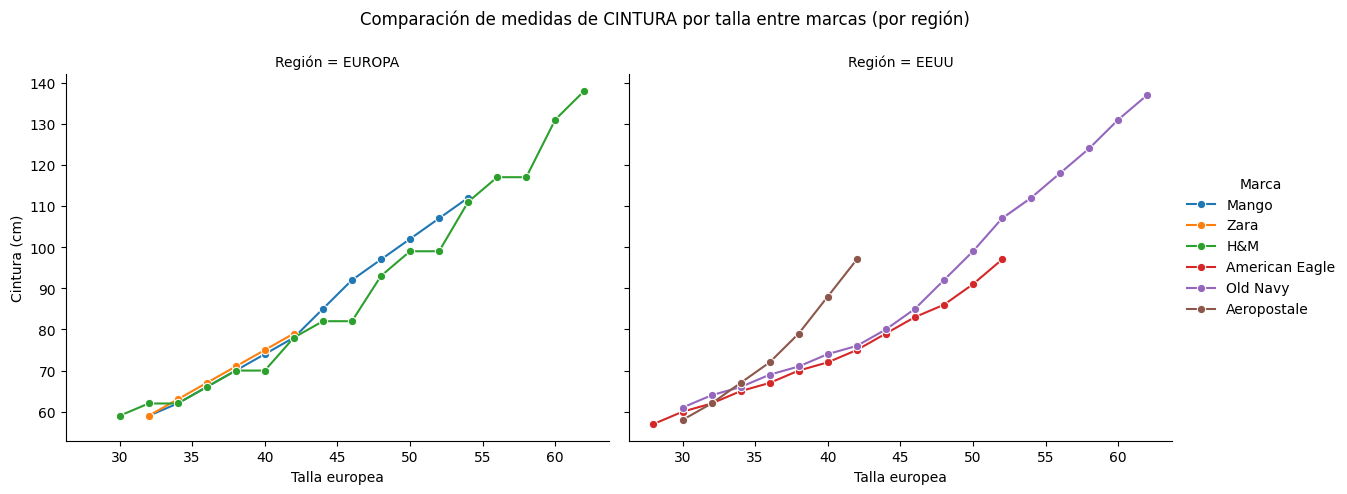

In [13]:
# Unir ambos datasets (asegúrate de que existan y tengan 'Región')
df_total = pd.concat([df_europa, df_usa_final], ignore_index=True)
df_total["Talla_EU"] = pd.to_numeric(df_total["Talla_EU"], errors="coerce")
df_total["Marca"] = df_total["Marca"].str.strip().str.title()
# Paleta con 6 colores únicos
colores = sns.color_palette("tab10", n_colors=6)


orden_marcas = ["Mango", "Zara", "H&M", "American Eagle", "Old Navy", "Aeropostale"]


g = sns.FacetGrid(
    df_total,
    col="Región",
    hue="Marca",
    hue_order=orden_marcas,
    height=5,
    aspect=1.2,
    palette=colores
)

g.map_dataframe(sns.lineplot, x="Talla_EU", y="Cintura", marker="o")
g.set_axis_labels("Talla europea", "Cintura (cm)")
g.add_legend()
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Comparación de medidas de CINTURA por talla entre marcas (por región)")

plt.show()

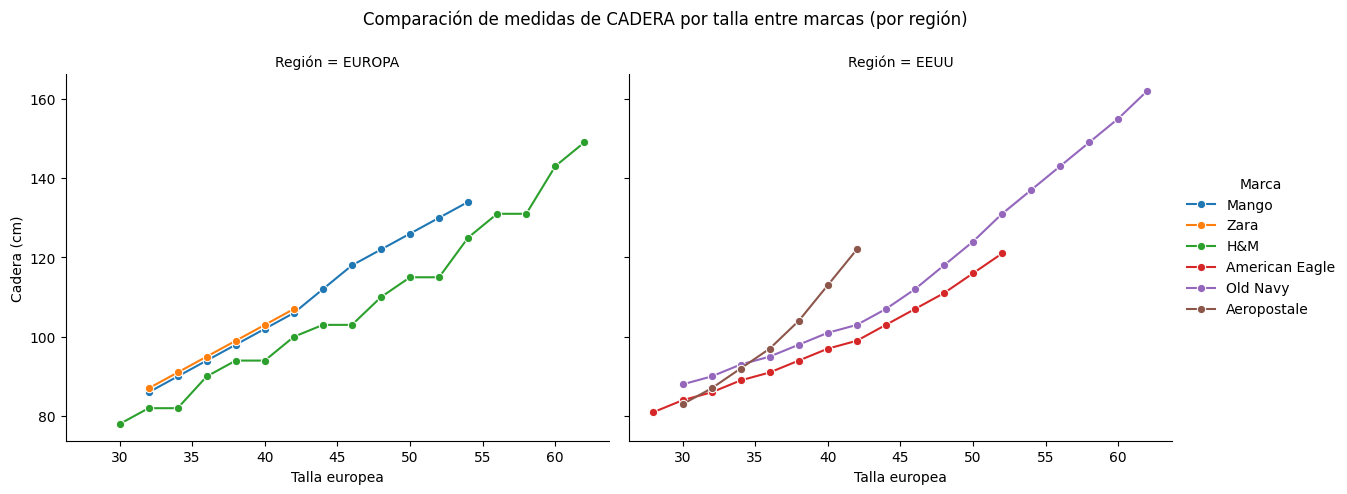

In [14]:
# Usamos las mismas marcas y colores para mantener consistencia
orden_marcas = ["Mango", "Zara", "H&M", "American Eagle", "Old Navy", "Aeropostale"]
colores = sns.color_palette("tab10", n_colors=len(orden_marcas))

# Gráfico de cadera
g = sns.FacetGrid(
    df_total,
    col="Región",
    hue="Marca",
    hue_order=orden_marcas,
    height=5,
    aspect=1.2,
    palette=colores
)

g.map_dataframe(sns.lineplot, x="Talla_EU", y="Cadera", marker="o")
g.set_axis_labels("Talla europea", "Cadera (cm)")
g.add_legend()
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Comparación de medidas de CADERA por talla entre marcas (por región)")

plt.show()

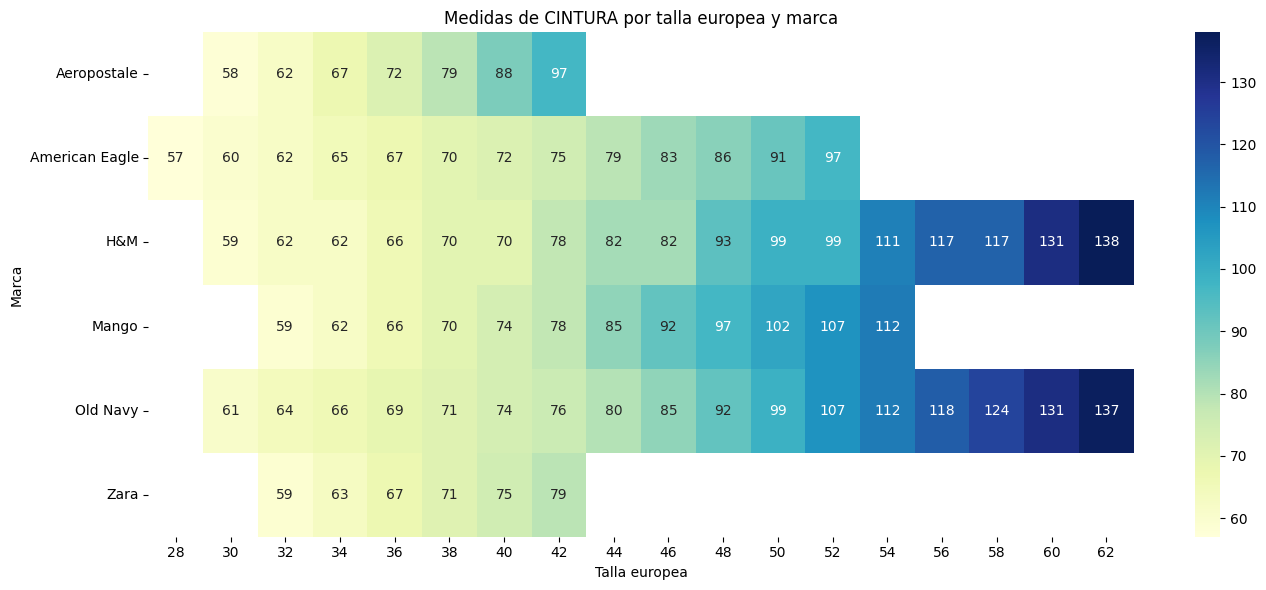

In [15]:
# Crear tabla pivote
pivot = df_total.pivot_table(index="Marca", columns="Talla_EU", values="Cintura")

# Heatmap de medidas de cintura por marca y talla
plt.figure(figsize=(14, 6))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".0f")
plt.title("Medidas de CINTURA por talla europea y marca")
plt.xlabel("Talla europea")
plt.ylabel("Marca")
plt.tight_layout()
plt.show()

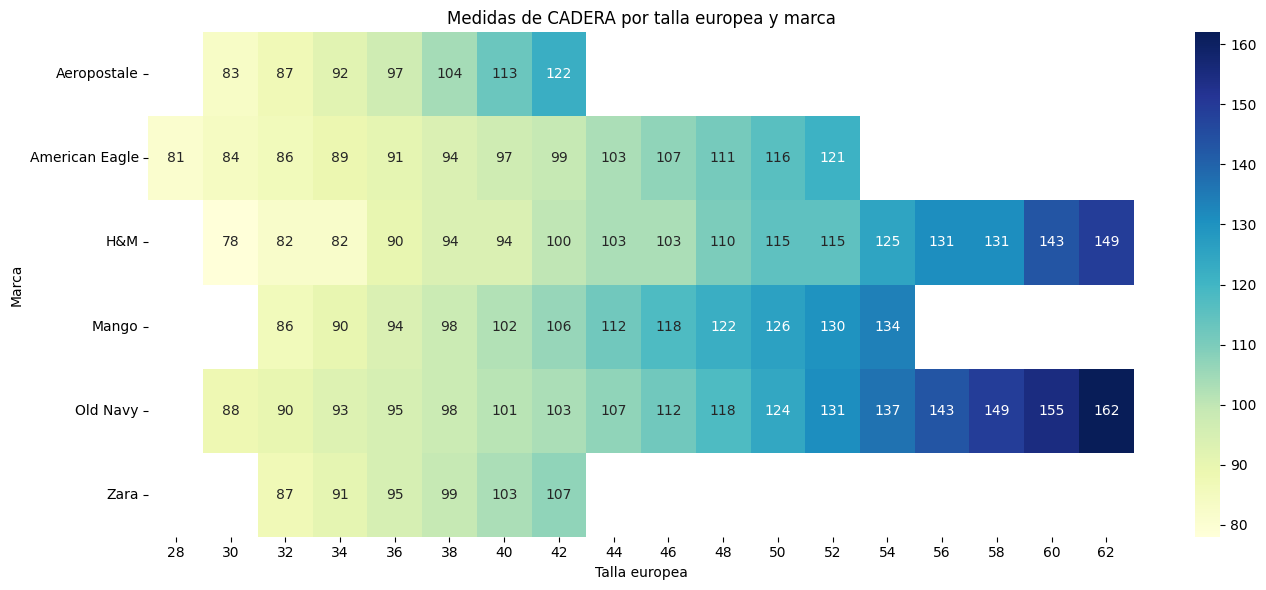

In [16]:
# Crear tabla pivote
pivot = df_total.pivot_table(index="Marca", columns="Talla_EU", values="Cadera")

# Heatmap de medidas de cintura por marca y talla
plt.figure(figsize=(14, 6))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".0f")
plt.title("Medidas de CADERA por talla europea y marca")
plt.xlabel("Talla europea")
plt.ylabel("Marca")
plt.tight_layout()
plt.show()

## Estandarización de tallas ISO 8559-2 y EN 13402

In [17]:
df_estandares_tallas = pd.DataFrame({
    "Talla (UE)": [32, 34, 36, 38, 40, 42, 44, 46, 48, 50],
    "Cintura EN 13402 (cm)": [60, 64, 68, 72, 76, 80, 84, 88, 92, 96],
    "Cintura ISO 8559-2 (cm)": [59, 62, 66, 70, 74, 78, 82, 86, 90, 94],
    "Cadera EN 13402 (cm)": [84, 88, 92, 96, 100, 104, 108, 112, 116, 120],
    "Cadera ISO 8559-2 (cm)": [86, 90, 94, 98, 102, 106, 110, 114, 118, 122]
})
df_estandares_tallas

,Talla (UE),Cintura EN 13402 (cm),Cintura ISO 8559-2 (cm),Cadera EN 13402 (cm),Cadera ISO 8559-2 (cm)
0,32,60,59,84,86
1,34,64,62,88,90
2,36,68,66,92,94
3,38,72,70,96,98
4,40,76,74,100,102
5,42,80,78,104,106
6,44,84,82,108,110
7,46,88,86,112,114
8,48,92,90,116,118
9,50,96,94,120,122


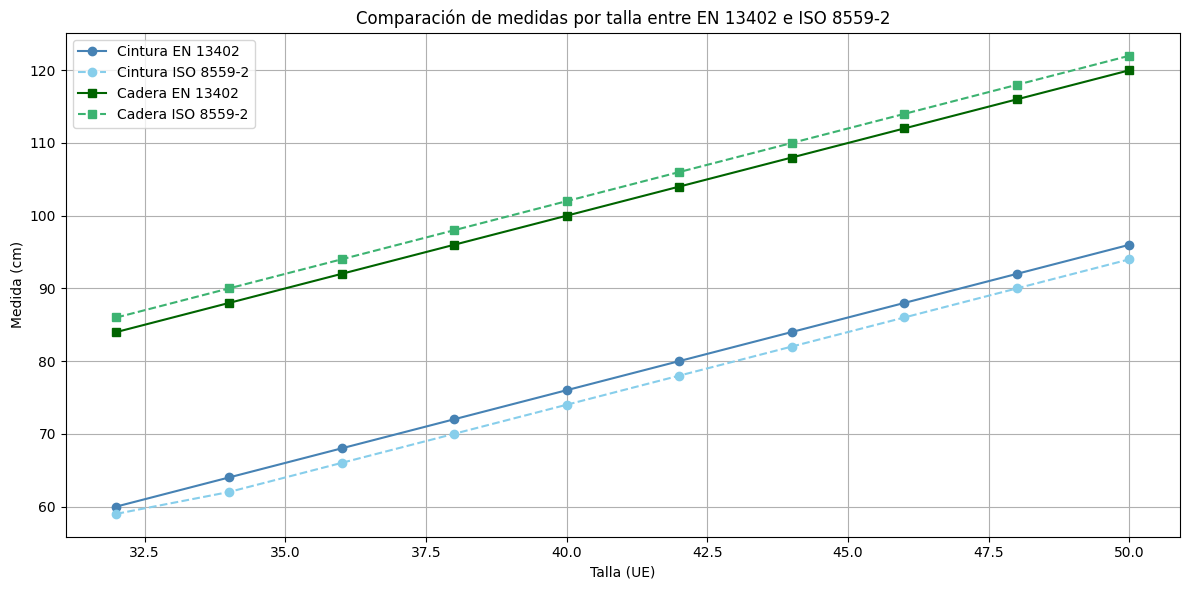

In [18]:
plt.figure(figsize=(12, 6))

# Graficar cintura
plt.plot(df_estandares_tallas["Talla (UE)"], df_estandares_tallas["Cintura EN 13402 (cm)"],
         marker='o', label="Cintura EN 13402", color='steelblue')
plt.plot(df_estandares_tallas["Talla (UE)"], df_estandares_tallas["Cintura ISO 8559-2 (cm)"],
         marker='o', label="Cintura ISO 8559-2", color='skyblue', linestyle='--')

# Graficar cadera
plt.plot(df_estandares_tallas["Talla (UE)"], df_estandares_tallas["Cadera EN 13402 (cm)"],
         marker='s', label="Cadera EN 13402", color='darkgreen')
plt.plot(df_estandares_tallas["Talla (UE)"], df_estandares_tallas["Cadera ISO 8559-2 (cm)"],
         marker='s', label="Cadera ISO 8559-2", color='mediumseagreen', linestyle='--')

# Configuración del gráfico
plt.title("Comparación de medidas por talla entre EN 13402 e ISO 8559-2")
plt.xlabel("Talla (UE)")
plt.ylabel("Medida (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Cruzar marcas y estandarización

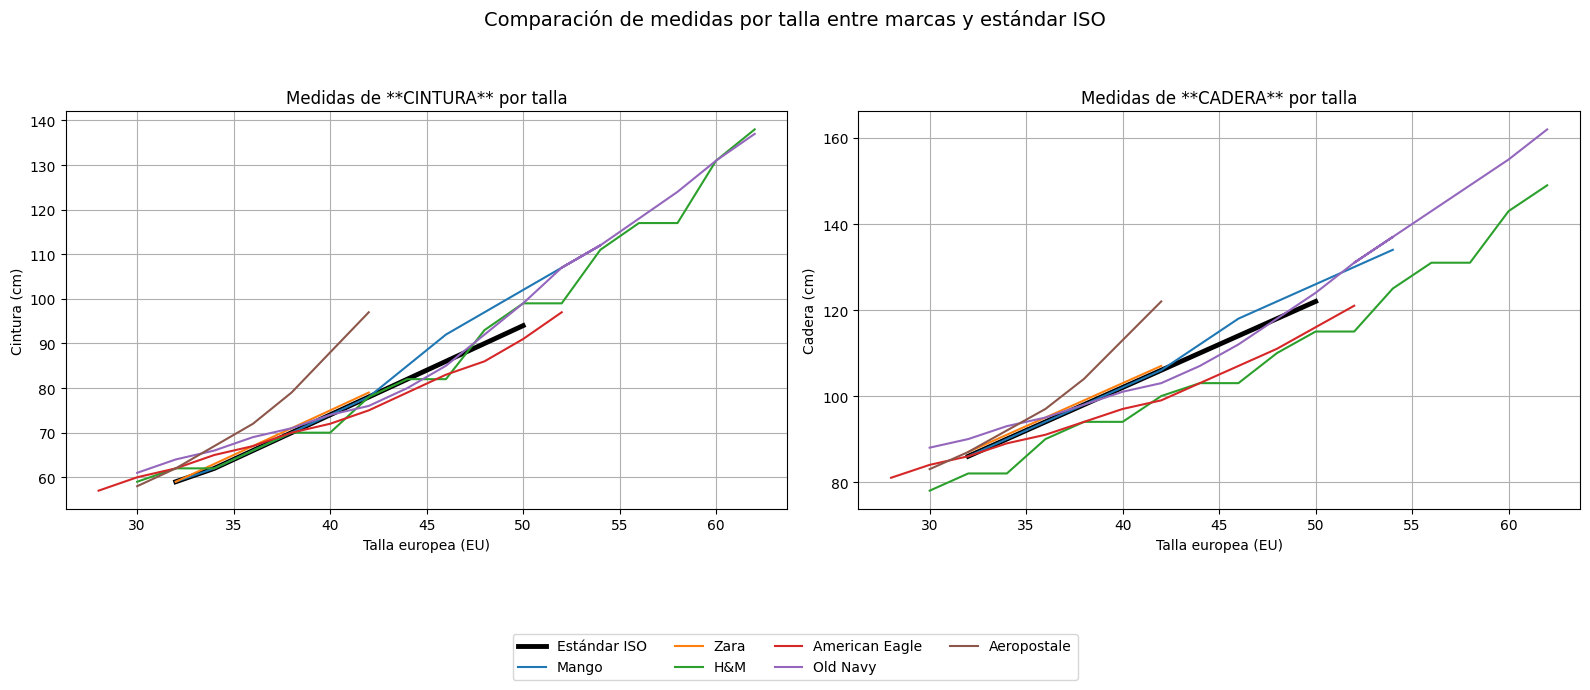

In [23]:

# unifique las marcas para generar un dataframe de marcas
df_europa['Región'] = 'Europa'
df_usa_final['Región'] = 'USA'

df_marcas = pd.concat([
    df_europa[['Talla_EU', 'Cintura', 'Cadera', 'Marca', 'Región']],
    df_usa_final[['Talla_EU', 'Cintura', 'Cadera', 'Marca', 'Región']]
], ignore_index=True)

# Cambio el nombre de talla ue para que sea igual al de el df de marcas 
df_estandares_tallas = df_estandares_tallas.rename(columns={'Talla (UE)': 'Talla_EU'})

# Me aseguro de que todo tenga el mismo formato de dato
df_marcas['Talla_EU'] = df_marcas['Talla_EU'].astype(int)
df_estandares_tallas['Talla_EU'] = df_estandares_tallas['Talla_EU'].astype(int)

# hago una join entre df standares y marcas 
df_total = df_marcas.merge(df_estandares_tallas, on='Talla_EU', how='left')


df_total = df_total.rename(columns={
    'Cintura ISO 8559-2 (cm)': 'Cintura_ISO',
    'Cadera ISO 8559-2 (cm)': 'Cadera_ISO'
})

# Genero una funcion para ver si estan dentro de los centimetros 
def esta_dentro(cintura, cadera, cintura_std, cadera_std):
    return (cintura >= cintura_std - 2) and (cintura <= cintura_std + 2) and \
           (cadera >= cadera_std - 2) and (cadera <= cadera_std + 2)

df_total['Dentro_Estandar'] = df_total.apply(
    lambda x: esta_dentro(x['Cintura'], x['Cadera'], x['Cintura_ISO'], x['Cadera_ISO']),
    axis=1
)

# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# --- SUBPLOT 1: CINTURA ---
axes[0].plot(
    df_estandares_tallas['Talla_EU'],
    df_estandares_tallas['Cintura ISO 8559-2 (cm)'],
    color='black',
    linewidth=3.5,
    label='Estándar ISO'
)
for marca in df_total['Marca'].unique():
    df_marca = df_total[df_total['Marca'] == marca]
    axes[0].plot(
        df_marca['Talla_EU'],
        df_marca['Cintura'],
        label=marca
    )
axes[0].set_title("Medidas de **CINTURA** por talla")
axes[0].set_xlabel("Talla europea (EU)")
axes[0].set_ylabel("Cintura (cm)")
axes[0].grid(True)

# --- SUBPLOT 2: CADERA ---
axes[1].plot(
    df_estandares_tallas['Talla_EU'],
    df_estandares_tallas['Cadera ISO 8559-2 (cm)'],
    color='black',
    linewidth=3.5,
    label='Estándar ISO'
)
for marca in df_total['Marca'].unique():
    df_marca = df_total[df_total['Marca'] == marca]
    axes[1].plot(
        df_marca['Talla_EU'],
        df_marca['Cadera'],
        label=marca
    )
axes[1].set_title("Medidas de **CADERA** por talla")
axes[1].set_xlabel("Talla europea (EU)")
axes[1].set_ylabel("Cadera (cm)")
axes[1].grid(True)

# Leyenda común fuera del gráfico
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=4)

plt.suptitle("Comparación de medidas por talla entre marcas y estándar ISO", fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.93])
plt.show()


# Cuerpos reales en Estados unidos vs Tallas en el Retail 

In [40]:
resultados = []

for marca, grupo in df_total.groupby(["Marca", "Región"]):
    cintura_min = grupo["Cintura"].min()
    cintura_max = grupo["Cintura"].max()
    cadera_min = grupo["Cadera"].min()
    cadera_max = grupo["Cadera"].max()

    fuera_rango = df_mujeres_adultas[
        (df_mujeres_adultas["Cintura"] < cintura_min) |
        (df_mujeres_adultas["Cintura"] > cintura_max) |
        (df_mujeres_adultas["Cadera"] < cadera_min) |
        (df_mujeres_adultas["Cadera"] > cadera_max)
    ]

    porcentaje_fuera = (len(fuera_rango) / len(df_mujeres_adultas)) * 100

    resultados.append({
        "Marca": marca[0],
        "Región": marca[1],
        "Porcentaje fuera de rango (%)": round(porcentaje_fuera, 2),
        "Total mujeres fuera de rango": len(fuera_rango)
    })

df_resultado = pd.DataFrame(resultados)
df_resultado

,Marca,Región,Porcentaje fuera de rango (%),Total mujeres fuera de rango
0,Aeropostale,USA,47.49,1069
1,American Eagle,USA,47.36,1066
2,H&M,Europa,3.33,75
3,Mango,Europa,23.68,533
4,Old Navy,USA,6.44,145
5,Zara,Europa,87.56,1971


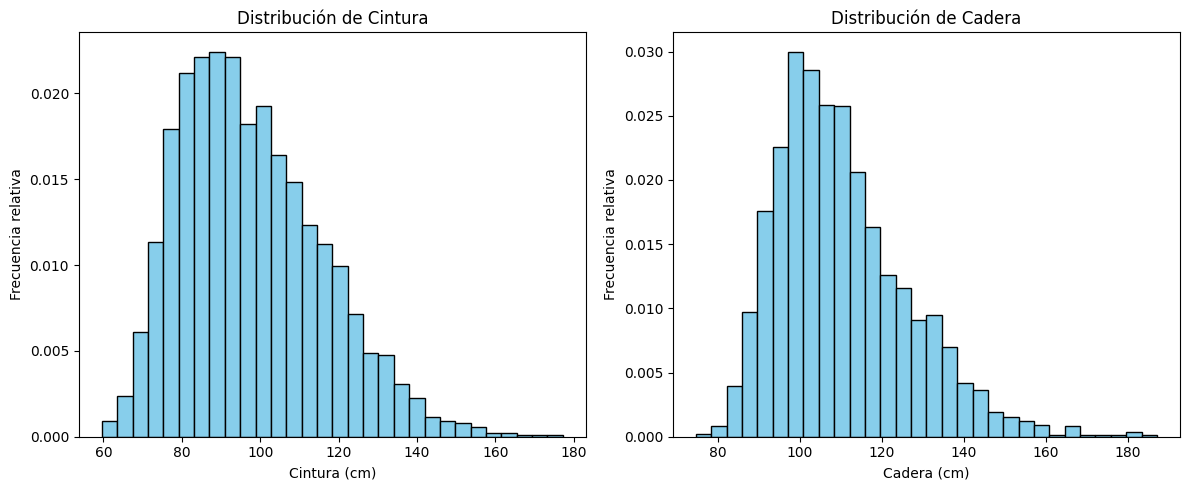

In [68]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_mujeres_adultas["Cintura"].plot.hist(bins=30, color="skyblue", edgecolor="black", density=True)
plt.title("Distribución de Cintura")
plt.xlabel("Cintura (cm)")
plt.ylabel("Frecuencia relativa")

plt.subplot(1, 2, 2)
df_mujeres_adultas["Cadera"].plot.hist(bins=30, color="skyblue", edgecolor="black", density=True)
plt.title("Distribución de Cadera")
plt.xlabel("Cadera (cm)")
plt.ylabel("Frecuencia relativa")

plt.tight_layout()
plt.show()

In [70]:
# Cintura 5% más bajo y el 95% más alto para generar rangos 
p5_cintura = df_mujeres_adultas["Cintura"].quantile(0.05) 
p95_cintura = df_mujeres_adultas["Cintura"].quantile(0.95)

# Cadera  5% más bajo y el 95% más alto para generar rangos 
p5_cadera = df_mujeres_adultas["Cadera"].quantile(0.05)
p95_cadera = df_mujeres_adultas["Cadera"].quantile(0.95)

print(f"Rango cintura: {p5_cintura:.1f} cm – {p95_cintura:.1f} cm")
print(f"Rango cadera: {p5_cadera:.1f} cm – {p95_cadera:.1f} cm")

Rango cintura: 72.8 cm – 131.0 cm
Rango cadera: 89.0 cm – 140.1 cm


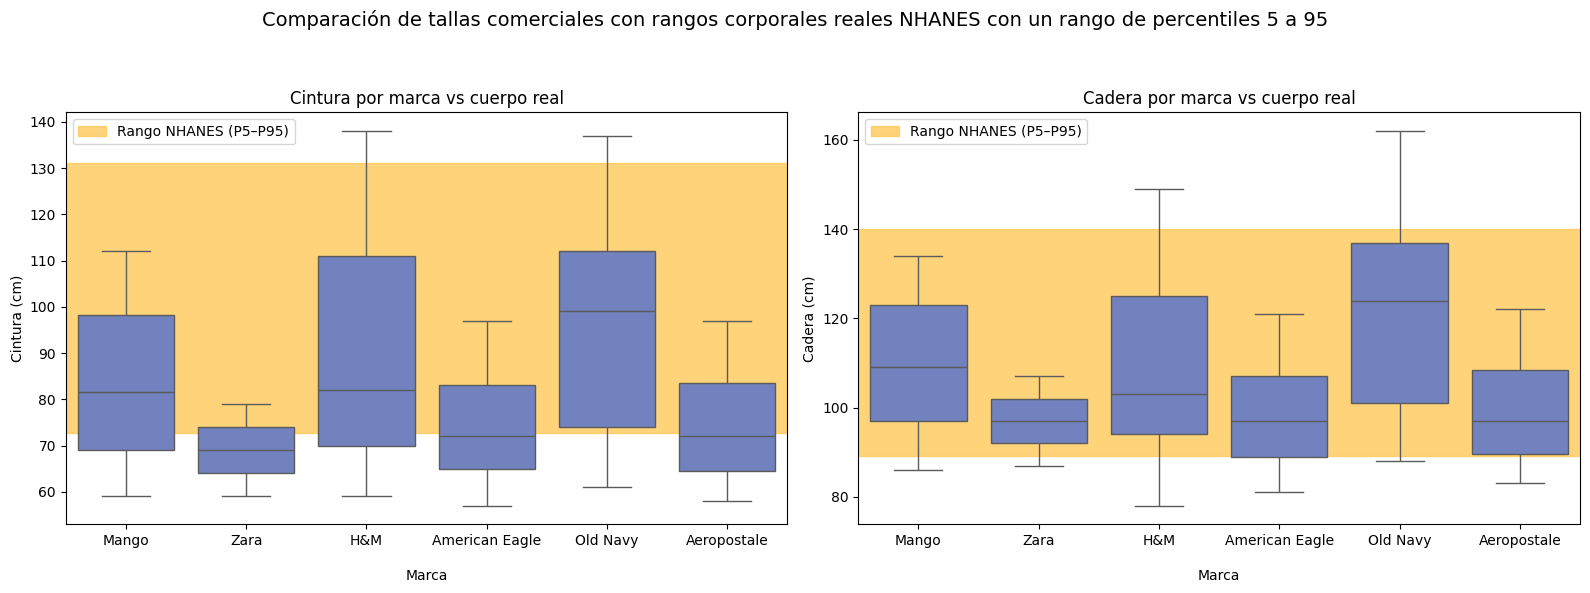

In [71]:
# Colores
light_blue = "#647bcc"   
fondo_nhanes = "#ffc859" 

# Crear gráfico
plt.figure(figsize=(16, 6))

# --- CINTURA ---
plt.subplot(1, 2, 1)
sns.boxplot(data=df_total, x="Marca", y="Cintura", color=light_blue)
plt.axhspan(p5_cintura, p95_cintura, color=fondo_nhanes, alpha=0.8, label="Rango NHANES (P5–P95)")
plt.title("Cintura por marca vs cuerpo real")
plt.ylabel("Cintura (cm)")
plt.xlabel("Marca")
plt.xlabel("Marca", labelpad=15)
plt.xticks(rotation=0)
plt.legend()

# --- CADERA ---
plt.subplot(1, 2, 2)
sns.boxplot(data=df_total, x="Marca", y="Cadera", color=light_blue)
plt.axhspan(p5_cadera, p95_cadera, color=fondo_nhanes, alpha=0.8, label="Rango NHANES (P5–P95)")
plt.title("Cadera por marca vs cuerpo real")
plt.ylabel("Cadera (cm)")
plt.xlabel("Marca")
plt.xlabel("Marca", labelpad=15)
plt.xticks(rotation=0)
plt.legend()

# Título general
plt.suptitle("Comparación de tallas comerciales con rangos corporales reales NHANES con un rango de percentiles 5 a 95", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()